# Reading in Polars and Data

In [1]:
import polars as pl
pl.Config.with_columns_kwargs = True

In [2]:
batting = pl.read_csv('Data/lahman baseball data/Batting.csv')
pitching = pl.read_csv('Data/lahman baseball data/Pitching.csv')
fielding = pl.read_csv('Data/lahman baseball data/Fielding.csv')
awards = pl.read_csv('Data/lahman baseball data/AwardsPlayers.csv')
salaries = pl.read_csv('Data/lahman baseball data/Salaries.csv')
salaries

yearID,teamID,lgID,playerID,salary
i64,str,str,str,i64
1985,"""ATL""","""NL""","""barkele01""",870000
1985,"""ATL""","""NL""","""bedrost01""",550000
1985,"""ATL""","""NL""","""benedbr01""",545000
1985,"""ATL""","""NL""","""campri01""",633333
1985,"""ATL""","""NL""","""ceronri01""",625000
…,…,…,…,…
2016,"""WAS""","""NL""","""strasst01""",10400000
2016,"""WAS""","""NL""","""taylomi02""",524000
2016,"""WAS""","""NL""","""treinbl01""",524900


# Gold Glove Data Set

In [3]:
fielding_awards = (fielding
.filter((pl.col('yearID') >= 2013))
.join(
     awards.rename({"notes": "POS"}) 
           .select(['playerID', 'yearID', 'awardID', 'lgID', 'POS'])  
           .filter((pl.col('awardID') == 'Gold Glove') & (pl.col('yearID') >= 2013)),
      on=['playerID', 'yearID', 'lgID'],
      how='left'
     )
.group_by(['playerID','yearID', 'lgID', 'POS', 'awardID'])
.agg(
     pl.col('InnOuts').sum().alias('InnOuts'),
     pl.col('PO').sum().alias('PO'),
     pl.col('A').sum().alias('A'),
     pl.col('E').sum().alias('E'),
     pl.col('DP').sum().alias('DP'),
     pl.col('PB').cast(int).sum().alias('PB'),
     pl.col('WP').cast(int).sum().alias('WP'),
     pl.col('SB').cast(int).sum().alias('SB'),
     pl.col('CS').cast(int).sum().alias('CS'),
     pl.col('ZR').cast(int).sum().alias('ZR') 
    )    
.with_columns(
        pl.when(pl.col('awardID').is_null())
          .then(pl.lit('No'))
          .otherwise(pl.lit('Yes'))
          .alias('Gold Glove?'),
         pl.when(pl.col('yearID') == 2023)
          .then(pl.lit('Validation'))
          .otherwise(pl.lit('Training'))
          .alias('Training-Validation')
              )
.drop(pl.col('awardID'))
                  )
# fielding_awards = fielding_awards.filter(pl.col('Gold Glove?') == 'Yes', pl.col('POS') == 'C', pl.col('yearID') == 2017)
fielding_awards.write_csv('data/fielding_awards.csv')

fielding_awards

playerID,yearID,lgID,POS,InnOuts,PO,A,E,DP,PB,WP,SB,CS,ZR,Gold Glove?,Training-Validation
str,i64,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str
"""chapmar01""",2021,"""AL""","""P""",169,0,3,3,0,0,0,0,0,0,"""No""","""Training"""
"""grubeja01""",2014,"""AL""","""P""",2,0,0,0,0,0,0,0,0,0,"""No""","""Training"""
"""brownse01""",2021,"""AL""","""OF""",1770,163,3,2,1,0,0,0,0,0,"""No""","""Training"""
"""reynoma03""",2022,"""NL""","""P""",4,0,0,0,0,0,0,0,0,0,"""No""","""Training"""
"""garciad02""",2018,"""NL""","""OF""",91,4,0,1,0,0,0,0,0,0,"""No""","""Training"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""nimmobr01""",2022,"""NL""","""OF""",3847,304,4,0,1,0,0,0,0,0,"""No""","""Training"""
"""aveliab01""",2018,"""NL""","""SS""",57,3,6,0,0,0,0,0,0,0,"""No""","""Training"""
"""gamelbe01""",2023,"""NL""","""OF""",78,7,0,2,0,0,0,0,0,0,"""No""","""Validation"""


# Salary Dataset

In [4]:
salaries_final = (salaries
.filter(pl.col('yearID') >= 2006)
.join(fielding
        .filter(pl.col('yearID') >= 2006),
        on=['playerID', 'yearID', 'lgID', 'teamID'],
        how='left'
     )
.join(batting
        .rename({"CS": "CS_batting", "SB": "SB_Batting"})
        .filter(pl.col('yearID') >= 2006),
        on=['playerID', 'yearID', 'teamID', 'stint', 'lgID', 'G'],
        how='left',
     )
.join(pitching
        .rename({
            "GIDP": "GIDP_pitching", "H": "H_pitching", "HR": "HR_pitching", "BB": "BB_pitching",
            "SO": "SO_pitching", "IBB": "IBB_pitching", "WP": "WP_pitching", "HBP": "HBP_pitching",
            "SH": "SH_pitching", "SF": "SF_pitching", "R": "R_pitching", "GIDP": "GIDP_pitching"
                })
        .filter(pl.col('yearID') >= 2006),
        on=['playerID', 'yearID', 'teamID', 'stint', 'lgID', 'G', 'GS'],
        how='left'
     )
.group_by(['playerID','yearID'])
.agg(
     pl.col('salary').sum().alias('salary'),
     pl.col('InnOuts').sum().alias('InnOuts'),
     pl.col('PO').sum().alias('PO'),
     pl.col('A').sum().alias('A'),
     pl.col('E').sum().alias('E'),
     pl.col('DP').sum().alias('DP'),
     pl.col('PB').cast(int).sum().alias('PB'),
     pl.col('WP').cast(int).sum().alias('WP'),
     pl.col('SB').cast(int).sum().alias('SB'),
     pl.col('CS').cast(int).sum().alias('CS'),
     pl.col('ZR').cast(int).sum().alias('ZR'),
     pl.col('G').sum().alias('G'),
     pl.col('AB').sum().alias('AB'),
     pl.col('R').sum().alias('R'),
     pl.col('H').sum().alias('H'),
     pl.col('2B').sum().alias('2B'),
     pl.col('3B').sum().alias('3B'),
     pl.col('HR').sum().alias('HR'),
     pl.col('SB_Batting').sum().alias('SB_batting'),
     pl.col('CS_batting').sum().alias('CS_batting'),
     pl.col('BB').sum().alias('BB_batting'),
     pl.col('SO').sum().alias('SO_batting'),
     pl.col('IBB').sum().alias('IBB_batting'),
     pl.col('HBP').sum().alias('HBP_batting'),
     pl.col('SH').sum().alias('Sacrifice Hits'),
     pl.col('SF').sum().alias('Sacrifice Flies'),
     pl.col('GIDP').sum().alias('GIDP'),
     pl.col('GS').sum().alias('GS'),
     pl.col('CG').sum().alias('CG'),
     pl.col('SHO').sum().alias('SHO'),
     pl.col('SV').sum().alias('SV'),
     pl.col('IPouts').sum().alias('IPOuts'),
     pl.col('H_pitching').sum().alias('H_pitching'),
     pl.col('ER').sum().alias('ER_pitching'),
     pl.col('HR_pitching').sum().alias('HR_pitching'),
     pl.col('BB_pitching').sum().alias('BB_pitching'),
     pl.col('SO_pitching').sum().alias('SO_pitching'),
     pl.col('BAOpp').sum().alias('BAOpp'),
     pl.col('ERA').sum().alias('ERA_pitching'),
     pl.col('IBB_pitching').sum().alias('IBB_pitching'),
     pl.col('WP_pitching').sum().alias('WP_pitching'),
     pl.col('HBP_pitching').sum().alias('HBP_pitching'),
     pl.col('BK').sum().alias('Balk'),
     pl.col('BFP').sum().alias('Batters Faced by Pitcher'),
     pl.col('GF').sum().alias('Games Finished'),
     pl.col('SH').sum().alias('SH_pitching'),
     pl.col('SF').sum().alias('SF_pitching'),
     pl.col('GIDP_pitching').sum().alias('GIDP_pitching')
    )   
.with_columns(
         pl.when(pl.col('yearID') == 2016)
          .then(pl.lit('Validation'))
          .otherwise(pl.lit('Training'))
          .alias('Training-Validation')
               )
)
salaries_final.write_csv('data/salaries_final.csv')
salaries_final

playerID,yearID,salary,InnOuts,PO,A,E,DP,PB,WP,SB,CS,ZR,G,AB,R,H,2B,3B,HR,SB_batting,CS_batting,BB_batting,SO_batting,IBB_batting,HBP_batting,Sacrifice Hits,Sacrifice Flies,GIDP,GS,CG,SHO,SV,IPOuts,H_pitching,ER_pitching,HR_pitching,BB_pitching,SO_pitching,BAOpp,ERA_pitching,IBB_pitching,WP_pitching,HBP_pitching,Balk,Batters Faced by Pitcher,Games Finished,SH_pitching,SF_pitching,GIDP_pitching,Training-Validation
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str
"""walljo02""",2013,490500,21,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,17,14,2,6,7,0.486,18.0,3,0,0,0,44,4,0,0,0,"""Training"""
"""moralke01""",2014,7410000,300,102,5,0,8,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,"""Training"""
"""pujolal01""",2014,46000000,3069,879,81,3,78,0,0,0,0,0,117,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,116,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,"""Training"""
"""claytro01""",2007,1500000,1500,73,176,7,30,0,0,0,0,0,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,55,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,"""Training"""
"""allenco01""",2016,4150000,204,3,6,0,1,0,0,0,0,0,67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,204,41,19,8,27,87,0.177,2.51,2,3,0,0,264,55,0,0,7,"""Validation"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""birdgr01""",2016,525300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,"""Validation"""
"""eatonad01""",2006,4650000,195,4,5,0,1,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,195,78,37,11,24,43,0.299,5.12,0,0,4,0,291,0,0,0,4,"""Training"""
"""zobribe01""",2014,21000000,3659,222,244,8,44,0,0,0,0,0,164,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,137,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,"""Training"""


# Classification Problem

## Setting Up

In [5]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
from sklearn.metrics import confusion_matrix

def get_metrics(y_true, y_pred, labels=None):
    """ Compute various measures from a confusion matrix

    Args:
        y_true: a column of the true labels.
        y_pred: a column of the predicted labels.
    Returns:
        A dictionary of metrics.
    """
    conf_mat = confusion_matrix(y_true, y_pred, labels=labels)
    tn, fp, fn, tp = conf_mat.ravel()

    return {'accuracy'          :  (tp + tn)/(tp + tn + fp + fn),
            'balanced_accuracy' :  0.5*tn / (tn+fp) + 0.5*tp / (tp+fn),
            'specificity'       :  tn / (tn+fp),
            'sensitivity'       :  tp / (tp+fn),
             'ppv'              :  tp / (tp + fp),
             'npv'              :  tn / (tn + fn)}


In [7]:
fielding_awards

playerID,yearID,lgID,POS,InnOuts,PO,A,E,DP,PB,WP,SB,CS,ZR,Gold Glove?,Training-Validation
str,i64,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str
"""chapmar01""",2021,"""AL""","""P""",169,0,3,3,0,0,0,0,0,0,"""No""","""Training"""
"""grubeja01""",2014,"""AL""","""P""",2,0,0,0,0,0,0,0,0,0,"""No""","""Training"""
"""brownse01""",2021,"""AL""","""OF""",1770,163,3,2,1,0,0,0,0,0,"""No""","""Training"""
"""reynoma03""",2022,"""NL""","""P""",4,0,0,0,0,0,0,0,0,0,"""No""","""Training"""
"""garciad02""",2018,"""NL""","""OF""",91,4,0,1,0,0,0,0,0,0,"""No""","""Training"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""nimmobr01""",2022,"""NL""","""OF""",3847,304,4,0,1,0,0,0,0,0,"""No""","""Training"""
"""aveliab01""",2018,"""NL""","""SS""",57,3,6,0,0,0,0,0,0,0,"""No""","""Training"""
"""gamelbe01""",2023,"""NL""","""OF""",78,7,0,2,0,0,0,0,0,0,"""No""","""Validation"""


In [8]:
fielding_awards.columns

['playerID',
 'yearID',
 'lgID',
 'POS',
 'InnOuts',
 'PO',
 'A',
 'E',
 'DP',
 'PB',
 'WP',
 'SB',
 'CS',
 'ZR',
 'Gold Glove?',
 'Training-Validation']

## Preparing Data

In [9]:
fielding_training = fielding_awards.filter(pl.col('Training-Validation') == 'Training').drop(['Gold Glove?', 'playerID', 'yearID', 'lgID', 'POS', 'Training-Validation'])
gold_glove_train = fielding_awards.filter(pl.col('Training-Validation') == 'Training').drop(['playerID', 'yearID', 'lgID', 'POS', 'Training-Validation']).select('Gold Glove?')

fielding_validation = fielding_awards.filter(pl.col('Training-Validation') == 'Validation').drop(['Gold Glove?', 'playerID', 'yearID', 'lgID', 'POS', 'Training-Validation'])
gold_glove_validation = fielding_awards.filter(pl.col('Training-Validation') == 'Validation').drop(['playerID', 'yearID', 'lgID', 'POS', 'Training-Validation']).select('Gold Glove?')

fielding_stats_train = fielding_training.to_pandas()
gold_glove_train = gold_glove_train.to_pandas()

fielding_stats_validation = fielding_validation.to_pandas()
gold_glove_validation = gold_glove_validation.to_pandas()

## Grid Search

### Tree Grid Search

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import numpy as np

In [11]:
param_grid = {'max_depth': [None, 1,2,3,4,5],
              'min_samples_split' : [1, 5, 10],
               'min_samples_leaf' : [1, 5, 10],
              'class_weight':["balanced"]
              }


In [12]:
from sklearn.model_selection import StratifiedKFold

In [13]:
state = 458

cv_obj = StratifiedKFold(n_splits=10, shuffle=True, random_state=state)

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, verbose=3, cv=cv_obj)

grid_search.fit(fielding_training, gold_glove_train)

Fitting 10 folds for each of 54 candidates, totalling 540 fits
[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf

C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
180 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py"

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=458, shuffle=True),
             estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [None, 1, 2, 3, 4, 5],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [1, 5, 10]},
             verbose=3)

In [45]:
grid_search.best_score_

np.float64(0.9559799758652066)

In [43]:
grid_search.best_params_

{'class_weight': 'balanced',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5}

In [44]:
best_model_tree = grid_search.best_estimator_
best_model_tree

DecisionTreeClassifier(class_weight='balanced', min_samples_split=5)

### Random Forest Grid Search

In [17]:
rf_param_grid = {'n_estimators':  [25, 50, 100],
              'max_depth': [None, 1,2,3,4,5],
              'min_samples_split' : [1, 5, 10],
               'min_samples_leaf' : [1, 5, 10],
              'class_weight':["balanced"]
              }

rf_param_grid

{'n_estimators': [25, 50, 100],
 'max_depth': [None, 1, 2, 3, 4, 5],
 'min_samples_split': [1, 5, 10],
 'min_samples_leaf': [1, 5, 10],
 'class_weight': ['balanced']}

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
rf_grid_search = GridSearchCV(RandomForestClassifier(), rf_param_grid, verbose=3, cv=cv_obj)

rf_grid_search.fit(fielding_training, gold_glove_train)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits
[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_spli

C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.976 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.983 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.980 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.978 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.982 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.976 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.979 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.978 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.972 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.969 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.967 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.982 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.976 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.979 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.980 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.972 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.980 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.980 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.967 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.978 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.977 total time=   1.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.977 total time=   1.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.980 total time=   1.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.977 total time=   1.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.981 total time=   1.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.980 total time=   1.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.977 total time=   1.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.980 total time=   1.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.974 total time=   1.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.980 total time=   1.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.976 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.979 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.978 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.976 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.978 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.971 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.978 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.979 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.966 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.975 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.975 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.977 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.977 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.975 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.977 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.975 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.974 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.975 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.971 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.978 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.977 total time=   1.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.983 total time=   1.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.978 total time=   1.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.974 total time=   1.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.978 total time=   1.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.975 total time=   1.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.976 total time=   1.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.975 total time=   1.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.973 total time=   1.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.975 total time=   1.2s
[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 7/10

C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.972 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.978 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.973 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.973 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.971 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.973 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.976 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.978 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.980 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.978 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.973 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.982 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.971 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.973 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.967 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.974 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.975 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.979 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.978 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.979 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.974 total time=   1.0s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.980 total time=   1.0s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.971 total time=   1.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.969 total time=   1.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.971 total time=   1.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.974 total time=   1.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.976 total time=   1.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.980 total time=   1.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.971 total time=   1.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.977 total time=   1.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.975 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.973 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.971 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.974 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.971 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.975 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.976 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.977 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.969 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.975 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.975 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.980 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.971 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.973 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.973 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.973 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.977 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.976 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.974 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.979 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.974 total time=   1.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.979 total time=   1.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.971 total time=   1.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.973 total time=   1.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.974 total time=   1.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.974 total time=   1.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.975 total time=   1.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.978 total time=   1.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.978 total time=   1.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.979 total time=   1.4s
[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[C

C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.960 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.970 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.961 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.970 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.962 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.974 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.961 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.967 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.969 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.966 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.965 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.974 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.964 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.963 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.963 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.964 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.969 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.967 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.963 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.966 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.964 total time=   1.0s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.974 total time=   1.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.961 total time=   1.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.963 total time=   1.0s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.962 total time=   1.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.965 total time=   1.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.965 total time=   1.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.968 total time=   1.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.962 total time=   1.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.968 total time=   1.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.963 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.970 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.957 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.962 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.963 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.968 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.966 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.964 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.963 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.964 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.965 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.971 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.968 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.964 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.962 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.966 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.965 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.971 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.962 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.968 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.973 total time=   1.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.974 total time=   1.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.967 total time=   1.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.962 total time=   1.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.962 total time=   1.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.965 total time=   1.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.965 total time=   1.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.969 total time=   1.0s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.967 total time=   1.0s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=None, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.968 total time=   1.5s
[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 7/10] END class_weigh

C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.883 total time=   0.1s
[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.869 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.870 total time=   0.1s
[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.870 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.880 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.851 total time=   0.1s
[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.857 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.827 total time=   0.1s
[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.869 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.820 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.875 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.858 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.822 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.835 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.822 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.847 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.872 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.880 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.865 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.848 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.829 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.849 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.859 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.869 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.834 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.868 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.863 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.842 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.868 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.851 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.828 total time=   0.1s
[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.874 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.889 total time=   0.1s
[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.899 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.839 total time=   0.1s
[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.882 total time=   0.0s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.833 total time=   0.1s
[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.840 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.872 total time=   0.1s
[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.837 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.827 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.840 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.854 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.867 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.854 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.846 total time=   0.1s
[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.868 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.879 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.870 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.826 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.882 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.828 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.854 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.843 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.836 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.829 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.868 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.855 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.877 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.851 total time=   0.5s
[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 7/10] END class_weight=ba

C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.873 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.804 total time=   0.1s
[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.849 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.853 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.815 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.839 total time=   0.1s
[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.880 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.849 total time=   0.1s
[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.852 total time=   0.0s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.815 total time=   0.0s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.870 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.853 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.838 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.862 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.857 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.863 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.870 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.874 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.866 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.846 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.854 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.846 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.862 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.866 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.867 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.875 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.885 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.848 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.867 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.855 total time=   0.4s
[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.807 total time=   0.0s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.818 total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.825 total time=   0.0s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.865 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.857 total time=   0.0s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.857 total time=   0.0s
[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.853 total time=   0.0s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.885 total time=   0.0s
[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.895 total time=   0.0s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.869 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.843 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.854 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.817 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.834 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.870 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.853 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.909 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.876 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.880 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.856 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.872 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.854 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.844 total time=   0.4s
[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.832 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.855 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.817 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.866 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.835 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.872 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.857 total time=   0.5s
[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 7/10] END class_wei

C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.816 total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.831 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.896 total time=   0.1s
[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.881 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.866 total time=   0.1s
[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.842 total time=   0.0s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.830 total time=   0.1s
[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.860 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.838 total time=   0.1s
[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.868 total time=   0.0s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.827 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.851 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.829 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.879 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.865 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.862 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.885 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.825 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.863 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.863 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.828 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.829 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.852 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.866 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.849 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.863 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.876 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.855 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.864 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.865 total time=   0.5s
[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.862 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.844 total time=   0.1s
[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.841 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.824 total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.837 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.911 total time=   0.1s
[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.841 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.821 total time=   0.1s
[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.883 total time=   0.1s
[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.832 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.830 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.875 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.852 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.818 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.848 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.864 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.827 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.844 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.858 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.874 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.856 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.847 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.827 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.851 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.855 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.847 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.861 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.873 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.849 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=1, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.860 total time=   0.5s
[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 7/10] END class_weight=b

C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.858 total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.823 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.868 total time=   0.1s
[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.851 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.868 total time=   0.1s
[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.855 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.870 total time=   0.1s
[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.846 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.860 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.851 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.850 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.838 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.827 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.853 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.857 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.862 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.865 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.867 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.891 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.812 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.845 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.844 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.852 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.864 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.867 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.866 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.855 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.882 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.855 total time=   0.5s
[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.834 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.800 total time=   0.1s
[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.811 total time=   0.0s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.872 total time=   0.1s
[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.822 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.849 total time=   0.1s
[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.881 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.838 total time=   0.1s
[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.845 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.818 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.835 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.851 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.838 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.860 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.848 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.868 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.881 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.836 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.890 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.868 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.854 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.853 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.836 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.838 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.858 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.862 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.877 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.856 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.860 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.863 total time=   0.5s
[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 7/10] END class_weight=ba

C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.826 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.849 total time=   0.1s
[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.852 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.852 total time=   0.1s
[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.895 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.837 total time=   0.1s
[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.856 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.868 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.842 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.854 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.850 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.836 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.857 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.833 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.838 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.898 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.848 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.882 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.863 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.850 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.843 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.855 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.842 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.860 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.868 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.885 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.865 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.885 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.818 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.898 total time=   0.1s
[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.824 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.839 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.851 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.819 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.839 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.851 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.873 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.830 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.859 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.844 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.850 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.849 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.824 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.879 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.841 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.854 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.864 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.868 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.842 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.844 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.860 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.869 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.863 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.859 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.868 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.851 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.842 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.860 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.869 total time=   0.7s
[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 7/10] END class_wei

C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.876 total time=   0.1s
[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.880 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.856 total time=   0.1s
[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.852 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.849 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.862 total time=   0.1s
[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.840 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.860 total time=   0.1s
[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.871 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.855 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.826 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.850 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.886 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.860 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.853 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.860 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.844 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.865 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.881 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.868 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.839 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.863 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.851 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.864 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.858 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.869 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.886 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.870 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.863 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.846 total time=   0.6s
[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.874 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.869 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.847 total time=   0.1s
[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.836 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.865 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.867 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.865 total time=   0.1s
[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.863 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.842 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.872 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.868 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.827 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.832 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.834 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.833 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.855 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.866 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.843 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.867 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.864 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.879 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.849 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.838 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.838 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.861 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.849 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.881 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.879 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.872 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=2, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.852 total time=   0.5s
[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 7/10] END class_weight=b

C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.871 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.884 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.872 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.856 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.876 total time=   0.1s
[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.903 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.912 total time=   0.1s
[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.873 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.910 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.893 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.863 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.878 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.890 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.873 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.872 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.890 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.872 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.895 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.893 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.878 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.890 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.886 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.873 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.879 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.885 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.903 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.860 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.875 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.920 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.876 total time=   0.6s
[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.867 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.898 total time=   0.1s
[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.881 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.886 total time=   0.2s
[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.891 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.834 total time=   0.1s
[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.905 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.901 total time=   0.1s
[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.902 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.871 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.871 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.900 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.881 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.885 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.888 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.932 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.906 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.877 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.914 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.892 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.878 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.891 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.881 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.875 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.880 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.898 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.914 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.881 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.902 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.877 total time=   0.7s
[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 7/10] END class_weight=ba

C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.877 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.894 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.893 total time=   0.1s
[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.856 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.858 total time=   0.1s
[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.872 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.876 total time=   0.1s
[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.911 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.929 total time=   0.1s
[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.879 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.862 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.864 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.875 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.868 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.891 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.889 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.884 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.871 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.895 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.873 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.879 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.885 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.896 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.893 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.881 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.911 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.907 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.886 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.911 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.879 total time=   0.6s
[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.877 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.874 total time=   0.1s
[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.873 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.872 total time=   0.1s
[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.848 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.924 total time=   0.1s
[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.899 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.879 total time=   0.1s
[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.913 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.896 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.861 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.878 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.869 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.900 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.884 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.904 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.912 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.906 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.913 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.888 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.894 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.877 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.891 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.874 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.900 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.893 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.895 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.893 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.885 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.896 total time=   0.6s
[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 7/10] END class_wei

C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.879 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.873 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.877 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.924 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.859 total time=   0.1s
[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.906 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.895 total time=   0.1s
[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.877 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.869 total time=   0.1s
[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.864 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.878 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.860 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.888 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.893 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.873 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.886 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.906 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.870 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.899 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.901 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.881 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.885 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.885 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.874 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.867 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.914 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.889 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.897 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.898 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.892 total time=   0.6s
[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.883 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.850 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.897 total time=   0.1s
[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.915 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.885 total time=   0.1s
[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.910 total time=   0.1s
[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.882 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.893 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.892 total time=   0.2s
[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.890 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.880 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.858 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.876 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.863 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.890 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.868 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.870 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.882 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.897 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.907 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.870 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.883 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.886 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.890 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.883 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.888 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.890 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.853 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.920 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=3, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.878 total time=   0.6s
[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 7/10] END class_weight=b

C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.901 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.923 total time=   0.1s
[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.904 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.894 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.912 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.925 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.906 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.911 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.930 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.889 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.903 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.902 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.897 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.920 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.916 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.919 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.913 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.910 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.919 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.891 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.910 total time=   0.9s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.918 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.907 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.924 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.914 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.926 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.921 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.906 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.925 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.895 total time=   0.6s
[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.897 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.906 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.908 total time=   0.2s
[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.919 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.916 total time=   0.1s
[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.926 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.895 total time=   0.1s
[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.918 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.924 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.887 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.909 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.913 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.905 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.911 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.905 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.925 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.911 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.911 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.915 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.892 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.907 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.917 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.907 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.905 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.905 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.929 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.911 total time=   0.9s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.901 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.919 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.914 total time=   0.7s
[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 7/10] END class_weight=ba

C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.913 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.904 total time=   0.1s
[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.909 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.922 total time=   0.1s
[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.905 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.911 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.908 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.907 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.915 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.899 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.907 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.904 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.907 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.917 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.911 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.910 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.914 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.911 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.925 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.908 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.908 total time=   0.9s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.913 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.907 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.919 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.913 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.926 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.921 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.911 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.926 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.909 total time=   0.7s
[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.910 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.901 total time=   0.1s
[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.907 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.913 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.923 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.936 total time=   0.1s
[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.912 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.904 total time=   0.2s
[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.912 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.900 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.906 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.914 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.908 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.920 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.906 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.914 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.915 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.910 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.924 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.908 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.911 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.924 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.907 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.914 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.906 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.925 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.918 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.906 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.926 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.898 total time=   0.7s
[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 7/10] END class_wei

C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.910 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.899 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.912 total time=   0.1s
[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.923 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.897 total time=   0.1s
[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.929 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.910 total time=   0.1s
[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.892 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.920 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.910 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.909 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.913 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.904 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.929 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.913 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.922 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.918 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.905 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.918 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.905 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.907 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.906 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.908 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.917 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.903 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.929 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.918 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.905 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.927 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.905 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.916 total time=   0.1s
[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.922 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.898 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.913 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.915 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.929 total time=   0.1s
[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.917 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.882 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.922 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.908 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.909 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.905 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.900 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.924 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.902 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.932 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.918 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.899 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.920 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.903 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.916 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.920 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.906 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.916 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.910 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.927 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.918 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.907 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.931 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=4, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.906 total time=   0.9s
[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 7/10] END class_weight=b

C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.925 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.932 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.919 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.929 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.917 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.945 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.934 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.927 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.938 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.925 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.921 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.932 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.916 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.933 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.923 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.944 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.926 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.919 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.924 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.915 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.927 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.933 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.925 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.928 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.927 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.940 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.933 total time=   0.9s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.923 total time=   1.0s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.934 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.920 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.916 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.932 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.925 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.940 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.911 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.933 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.935 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.915 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.936 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=25;, score=0.915 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.933 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.924 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.920 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.933 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.918 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.942 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.926 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.926 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.930 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=0.918 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.919 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.931 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.928 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.933 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.921 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.935 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.934 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.924 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.941 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.916 total time=   0.7s
[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 7/10] END class_weight=ba

C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.935 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.924 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.923 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.924 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.921 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.941 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.931 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.929 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.937 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=25;, score=0.927 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.920 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.929 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.916 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.925 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.913 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.940 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.924 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.928 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.928 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=50;, score=0.926 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.929 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.929 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.917 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.935 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.920 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.942 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.931 total time=   0.9s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.924 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.933 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100;, score=0.924 total time=   0.9s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.922 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.927 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.924 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.925 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.927 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.933 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.932 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.920 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.943 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=25;, score=0.914 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.924 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.924 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.924 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.931 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.923 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.942 total time=   0.6s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.937 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.921 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.937 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=50;, score=0.917 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.931 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.933 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.922 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.932 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.929 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.945 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.932 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.928 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.935 total time=   0.9s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=5, min_samples_split=10, n_estimators=100;, score=0.926 total time=   0.8s
[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=1, n_estimators=25;, score=nan total time=   0.0s
[CV 7/10] END class_wei

C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.932 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.940 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.920 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.928 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.928 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.927 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.924 total time=   0.1s
[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.911 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.932 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=25;, score=0.924 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.922 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.924 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.918 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.933 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.920 total time=   0.5s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.935 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.929 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.923 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.927 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=50;, score=0.921 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.922 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.931 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.923 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.930 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.921 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.937 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.933 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.928 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.932 total time=   0.7s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=5, n_estimators=100;, score=0.925 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.923 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.928 total time=   0.2s
[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.917 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.941 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.912 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.934 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.923 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.935 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.932 total time=   0.1s
[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=25;, score=0.916 total time=   0.1s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.927 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.927 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.918 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.932 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.925 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.936 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.933 total time=   0.2s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.916 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.930 total time=   0.4s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=50;, score=0.922 total time=   0.3s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 1/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.927 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 2/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.927 total time=   0.9s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 3/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.917 total time=   0.9s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 4/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.929 total time=   0.9s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 5/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.920 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 6/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.937 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 7/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.931 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 8/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.929 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 9/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.928 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV 10/10] END class_weight=balanced, max_depth=5, min_samples_leaf=10, min_samples_split=10, n_estimators=100;, score=0.925 total time=   0.8s


C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=458, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [None, 1, 2, 3, 4, 5],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [1, 5, 10],
                         'n_estimators': [25, 50, 100]},
             verbose=3)

In [46]:
rf_grid_search.best_score_

np.float64(0.9783273534112442)

In [47]:
rf_grid_search.best_params_

{'class_weight': 'balanced',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 100}

In [48]:
best_model_rf = rf_grid_search.best_estimator_
best_model_rf

RandomForestClassifier(class_weight='balanced', min_samples_split=5)

### Comparing Scores

In [49]:
rf_grid_search.best_score_ > grid_search.best_score_

np.True_

### Measuring Performance

In [50]:
gold_glove_validation_pred_rf = rf_grid_search.predict(fielding_validation)

In [51]:
get_metrics(gold_glove_validation, gold_glove_validation_pred_rf)

{'accuracy': np.float64(0.9811503141614306),
 'balanced_accuracy': np.float64(0.514917407433331),
 'specificity': np.float64(0.9941205291523763),
 'sensitivity': np.float64(0.03571428571428571),
 'ppv': np.float64(0.07692307692307693),
 'npv': np.float64(0.9868677042801557)}

## Fitting the Best Model

In [52]:
forest = RandomForestClassifier(min_samples_leaf=5, min_samples_split=10, n_estimators=10)
forest.fit(fielding_training, gold_glove_train)

C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(min_samples_leaf=5, min_samples_split=10,
                       n_estimators=10)

## ROC Curve

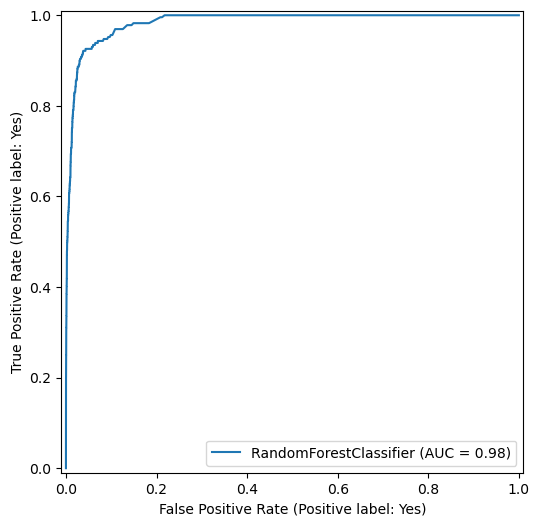

In [53]:
from sklearn.metrics import RocCurveDisplay

plt.rcParams["figure.figsize"] = (8,6)

RocCurveDisplay.from_estimator(forest, fielding_training, gold_glove_train)

plt.show()

## AUC

In [54]:
def get_class_prob_df(clf, X):
    """ Return a dataframe of class probabilities.

    Arg:
        clf:  A fitted model object
        X:    The matrix of (test) features.
    Returns: A dataframe of class probabilities
    """
    return pd.DataFrame(clf.predict_proba(X), columns=clf.classes_)

In [55]:
y_test_probs = get_class_prob_df(forest, fielding_validation)

y_test_probs

,No,Yes
0,0.999025,0.000975
1,0.996139,0.003861
2,0.999934,0.000066
3,1.000000,0.000000
4,1.000000,0.000000
...,...,...
2064,0.999124,0.000876
2065,0.999161,0.000839
2066,1.000000,0.000000
2067,0.999161,0.000839


In [56]:
from sklearn.metrics import roc_auc_score

roc_auc_score(gold_glove_validation, y_test_probs['Yes'])

np.float64(0.7950409463148318)

## Balanced Success

In [57]:
forest = RandomForestClassifier(min_samples_leaf=5, min_samples_split=10, n_estimators=10)
forest.fit(fielding_training, gold_glove_train)

y_test_pred = forest.predict(fielding_validation)
y_test_prob = get_class_prob_df(forest, fielding_validation)

C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [58]:
forest2 = RandomForestClassifier()
forest2.fit(fielding_training, gold_glove_train)

y_test_pred2 = forest.predict(fielding_validation)
y_test_prob2 = get_class_prob_df(forest2, fielding_validation)

C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [59]:
get_metrics(gold_glove_validation, y_test_pred)

C:\Users\hp6265bz\AppData\Local\Temp\ipykernel_17108\987674393.py:19: RuntimeWarning: invalid value encountered in scalar divide
  'ppv'              :  tp / (tp + fp),


{'accuracy': np.float64(0.9864668922184631),
 'balanced_accuracy': np.float64(0.5),
 'specificity': np.float64(1.0),
 'sensitivity': np.float64(0.0),
 'ppv': np.float64(nan),
 'npv': np.float64(0.9864668922184631)}

In [60]:
get_metrics(gold_glove_validation, y_test_pred2)

C:\Users\hp6265bz\AppData\Local\Temp\ipykernel_17108\987674393.py:19: RuntimeWarning: invalid value encountered in scalar divide
  'ppv'              :  tp / (tp + fp),


{'accuracy': np.float64(0.9864668922184631),
 'balanced_accuracy': np.float64(0.5),
 'specificity': np.float64(1.0),
 'sensitivity': np.float64(0.0),
 'ppv': np.float64(nan),
 'npv': np.float64(0.9864668922184631)}

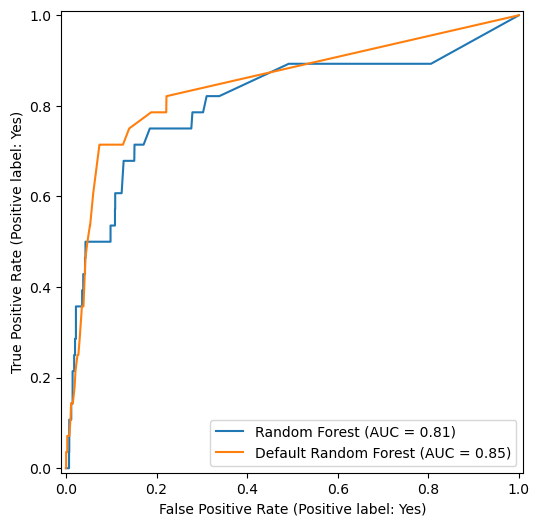

In [61]:
ax = plt.gca()

RocCurveDisplay.from_estimator(forest, fielding_validation, gold_glove_validation, ax = ax, name = "Random Forest")
RocCurveDisplay.from_estimator(forest2, fielding_validation, gold_glove_validation, ax = ax, name = "Default Random Forest")

plt.show()

In [62]:
roc_auc_score(gold_glove_validation, y_test_probs['Yes'])

np.float64(0.7950409463148318)

In [63]:
roc_auc_score(gold_glove_validation, y_test_prob2['Yes'])

np.float64(0.8469325260726535)

# Regression Problem

## Preparing Data

In [78]:
salaries.columns

['yearID', 'teamID', 'lgID', 'playerID', 'salary']

In [79]:
salaries_training = salaries_final.filter(pl.col('Training-Validation') == 'Training').drop('playerID','yearID','salary', 'Training-Validation')
salary_train = salaries_final.filter(pl.col('Training-Validation') == 'Training').drop('playerID','yearID','Training-Validation').select('salary')

salaries_validation = salaries_final.filter(pl.col('Training-Validation') == 'Validation').drop('playerID','yearID','salary', 'Training-Validation')
salary_validation = salaries_final.filter(pl.col('Training-Validation') == 'Validation').drop('playerID','yearID','Training-Validation').select('salary')

salaries_training = salaries_training.to_pandas()
salary_train = salary_train.to_pandas()

salaries_validation = salaries_validation.to_pandas()
salary_validation = salary_validation.to_pandas()


In [80]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## Tree Grid Search

In [ ]:
tree_param_grid = {
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

from sklearn.model_selection import StratifiedKFold

state = 458

cv_obj = StratifiedKFold(n_splits=10, shuffle=True, random_state=state)

grid_search_tree_regressor = GridSearchCV(DecisionTreeRegressor(), tree_param_grid, verbose=3, cv=cv_obj)

grid_search_tree_regressor.fit(salaries_training, salary_train)

In [82]:
grid_search_tree_regressor.best_score_

np.float64(0.11583653929710355)

In [83]:
grid_search_tree_regressor.best_params_

{'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 5}

In [84]:
best_model_tree_regressor = grid_search_tree_regressor.best_estimator_
best_model_tree_regressor

DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, min_samples_split=5)

## Forest Grid Search

In [ ]:
rf_param_grid = {
    'n_estimators': [10, 25, 50],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

from sklearn.model_selection import StratifiedKFold

state = 458

cv_obj = StratifiedKFold(n_splits=10, shuffle=True, random_state=state)

grid_search_forest_r = GridSearchCV(RandomForestRegressor(), rf_param_grid, verbose=3, cv=cv_obj)

grid_search_forest_r.fit(salaries_training, salary_train)

In [99]:
grid_search_forest_r.best_score_

np.float64(0.17714343487183135)

In [100]:
grid_search_forest_r.best_params_

{'max_depth': 10,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'n_estimators': 50}

In [90]:
best_model_forest_r = grid_search_forest_r.best_estimator_
best_model_forest_r

RandomForestRegressor(max_depth=10, min_samples_leaf=5, min_samples_split=10,
                      n_estimators=50)

## Comparing Scores

In [98]:
grid_search_forest_r.best_score_ > grid_search_tree_regressor.best_score_

np.True_

## Measuring Performance

In [103]:
salaries_validation_pred_rf = grid_search_forest_r.predict(salaries_validation)

## Fitting the Best Model

In [94]:
forest = RandomForestRegressor(min_samples_leaf=5, n_estimators=200)
forest.fit(salaries_training, salary_train)

C:\Users\hp6265bz\AppData\Local\anaconda3\envs\polars\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(min_samples_leaf=5, n_estimators=200)

## Root MSE & $R^2$

In [95]:
from sklearn.metrics import explained_variance_score, mean_squared_error

In [96]:
salary_validation_pred = forest.predict(salaries_validation)

salary_validation_pred

array([ 4096008.65837463,  5611618.09615246,   953609.27187029,
        1658053.58027014,  2622856.95775988,  3847526.68427599,
        3945901.64436739,  5384578.11156027,  6768236.07736794,
        4075888.42781942,  1496382.15766016,  3413089.37712774,
        3197807.46893556,  5756633.94815178,  6785985.60141406,
        9081744.7105957 , 10878421.20112203,  2412939.04618074,
        4496461.99354141,  1434343.16190296,  5602818.2000135 ,
        3477922.94953648,  3977402.06498875,  1224593.37505945,
        9322233.0969347 ,  5514022.29886535,  1381191.16338634,
        2412939.04618074,  2607762.34940296,  4097618.20447542,
        5093133.40520412,  1515653.56538036,  6146853.8539432 ,
        4618451.74079505,  8186437.44048498,  2474555.38808404,
        4208446.70525167,  6277507.73810624,  4548649.01966758,
        8080124.78380549,  9564604.92431255,  5902424.68390753,
        1241479.98695843,  1248873.28267169,  3662613.53011886,
        1444444.83433406,  2694370.81566

In [102]:
{
 'R^2': explained_variance_score(salary_validation, salary_validation_pred),
 'RMSE': np.sqrt(mean_squared_error(salary_validation, salary_validation_pred))
}

{'R^2': 0.2181692795087813, 'RMSE': np.float64(6476237.415883971)}